# Задача 1
Создадим функцию для подсчета подневного Retention игроков мобильной игры.  

In [41]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency

In [2]:
# прочитаем данные и посмотрим на них
reg = pd.read_csv('problem1-reg_data.csv', sep = ';')
auth = pd.read_csv('problem1-auth_data.csv', sep = ';')

Проведем небольшую разведку данных

In [3]:
reg.head(2)

,reg_ts,uid
0,911382223,1
1,932683089,2


In [4]:
reg.dtypes

reg_ts    int64
uid       int64
dtype: object

In [5]:
auth.head(2)

,auth_ts,uid
0,911382223,1
1,932683089,2


In [6]:
auth.dtypes

auth_ts    int64
uid        int64
dtype: object

In [7]:
reg.dtypes

reg_ts    int64
uid       int64
dtype: object

Видим, что у нас дата в int, но по сути это UNIX timestamp. Примем это во внимание.

In [8]:
# Смотрим на наличие пропущенных значений.
reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [9]:
auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [10]:
auth.head(2)

,auth_ts,uid
0,911382223,1
1,932683089,2


Пропущенных значений у нас нет. С датафреймами можно работать. Есть нюанс, что судя по разнице таймстемп значений, период у нас довольно большой. Необходимо в функцию также добавить возможно ограничивать период поиска, чтобы можно было извлекать нужный период и строить удобную сводную таблицу с показалетем Retention

In [11]:
def retention_rate(data_reg, data_auth, min_date, max_date, lifetime_days):
    """Для получения retention n-дней для определенного периода необходимо ввести следующие данные:
    data_reg - путь к файлу с информацией о регистрации пользователей;
    data_auth - путь к файлу с датой захода пользователей в приложение;
    min_date - минимальная дата регистрации пользователей, она же первая когорта;
    max_date - максимальная дата регистрации пользователей, она же последняя когорта;
    lifetime_days - время жизни когорт, исчисляемое количеством дней с момента регистрации.
    В итоге мы получим сводную таблицу retention n-дней в процентах по когортам.
    """
    #Читаем файлы
    reg_data = pd.read_csv(data_reg, sep=';')
    auth_data = pd.read_csv(data_auth, sep=';')
    
    min_date = pd.to_datetime(min_date)
    max_date = pd.to_datetime(max_date)
    lifetime_days = lifetime_days
 
    
    #переводим дату в нормальный формат из UNIX-timestamp
    reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit = 's').dt.date
    auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit = 's').dt.date
    reg_data['reg_ts'] = reg_data['reg_ts'].astype('datetime64[D]')
    auth_data['auth_ts'] = auth_data['auth_ts'].astype('datetime64[D]')

    
    #соединяем 
    full_data = auth_data.merge(reg_data, on = 'uid', how = 'left')
    
    #ограничиваем датасет интересующими нас датами для сокращения времени обработки дальнейших действий.
    full_data = full_data[(full_data.reg_ts >= min_date) & (full_data.reg_ts <= max_date)]
    
    #Вычисляем время жизни каждой когорты в количестве дней. 
    full_data['cohort_lifetime'] = full_data['auth_ts'] - full_data['reg_ts']
    full_data['cohort_lifetime'] = full_data['cohort_lifetime'] / np.timedelta64(1, 'D')
    full_data['cohort_lifetime'] = full_data['cohort_lifetime'].round().astype(int)
    
    #органичиваем время жизни когорт
    full_data = full_data[full_data.cohort_lifetime <= lifetime_days]
    
    #группируем для получения количества пользователей в каждый день жизни когорты:
    cohorts = full_data.groupby(['reg_ts','cohort_lifetime'], as_index = False).agg({'uid':'nunique'})
    
    # Получем отдельную колонку с количеством пользователей в каждой когорте
    install_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['reg_ts','uid']]
    install_users_count = install_users_count.rename(columns={'uid':'cohort_users'})
    cohorts = cohorts.merge(install_users_count, on='reg_ts')
    
    #вычисляем Retention
    cohorts['retention'] = (cohorts['uid']/cohorts['cohort_users'])
    
    
    retention_pivot = cohorts.pivot(
    index=['reg_ts', 'cohort_users'], columns='cohort_lifetime',
    values='retention')

    # удаляем первый столбец, т.к. он соответствует lifetime = 0
    retention_pivot = retention_pivot.drop(columns=[0])
    
    retention_visual = (retention_pivot \
                   .style \
                   .set_caption(f'Retention первых {lifetime_days} дней') \
                   .background_gradient(cmap='Reds', axis=1) \
                   .highlight_null('white') \
                   .format("{:.1%}") \
                   .set_properties(**{'width': '100px'}))

    
    return retention_visual

У нас есть функция, теперь подготовим данные для ввода, чтобы сократить время обработки.

In [12]:
# Задаем значение параметров для функции
data_reg = 'problem1-reg_data.csv'
data_auth = 'problem1-auth_data.csv'
min_date = '2020-09-09'
max_date = '2020-09-15'
lifetime_days = 7

In [13]:
# Проверяем:
retention_rate(data_reg, data_auth, min_date, max_date, lifetime_days)

,cohort_lifetime,1,2,3,4,5,6,7
reg_ts,cohort_users,,,,,,,
2020-09-09 00:00:00,1607,1.7%,3.2%,4.7%,5.7%,6.7%,5.7%,5.9%
2020-09-10 00:00:00,1609,2.1%,4.3%,4.8%,4.2%,6.8%,6.3%,7.1%
2020-09-11 00:00:00,1612,1.3%,4.0%,4.5%,5.6%,5.7%,6.7%,6.3%
2020-09-12 00:00:00,1614,1.9%,3.8%,4.7%,4.6%,6.1%,6.6%,5.8%
2020-09-13 00:00:00,1618,2.0%,4.1%,4.3%,5.1%,6.6%,6.5%,4.9%
2020-09-14 00:00:00,1619,2.2%,3.8%,4.5%,5.3%,6.5%,7.0%,6.3%
2020-09-15 00:00:00,1623,2.2%,4.1%,4.6%,6.0%,5.6%,6.9%,5.7%


Задача выполнена, теперь с можно задавать искомый период и с помощью функции строить график Retention.

# Задача 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [43]:
# посмотрим на данные:
ab_results = pd.read_csv('a_b_results.csv', sep = ';')

In [44]:
ab_results.head(2)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a


In [45]:
ab_results.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [46]:
ab_results.user_id.nunique()

404770

Итак, на что мы можем посмотреть, чтобы сделать выводы о том, какой набор предложений можно считать лучшим?
1. Можем статистически проверить показатель ARPU. 5% это много или мало? и будет ли это стат. значимо?
2. Можем статистически проверить показатель ARPPU и выяснить, стали ли наши платящие пользователи платить больше.
3. Можем проанализировать количество платящих пользователей в каждой группе. Имеется ли статистически значимая связь между группой теста и количеством платящих пользователей.

Проверяем первую теорию. ARPU или Average revenue per user считается по формуле SUM revenue / количество уникальных пользователей. Если мы сравним средние показатели в двух группах с помощью стат. теста, то это и будет сравнение ARPU.

In [48]:
# разделим датасет на тестовый и контрольный для удобства

In [47]:
control_data = ab_results.query('testgroup == "a"')
test_data = ab_results.query('testgroup == "b"')

Для посмотрим на показатели ARPU в контрольной и тестовой группах

In [21]:
ARPU_control =  control_data.revenue.sum() / control_data.user_id.count()
print(ARPU_control)

25.413719736965806


In [22]:
ARPU_test = test_data.revenue.sum() / test_data.user_id.count()
print(ARPU_test)

26.75128659327863


In [23]:
(ARPU_test - ARPU_control) / ARPU_control * 100

5.263168360069894

Итак, ARPU в контрольной группе равен 25.4, а ARPU в тестовой группе равен 25.8. Разница в ARPU действительно 5 %. Проверим, статистически значима ли эта разница.

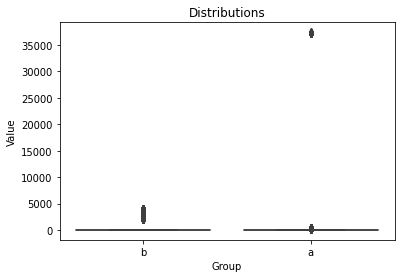

In [24]:
# Посмотрим на распределения в тестовой и контрольной группах
sns.boxplot(x='testgroup', y='revenue', data=ab_results)

# добавление подписей к осям и заголовка
plt.xlabel('Group')
plt.ylabel('Value')
plt.title('Distributions')
sns.set(rc={'figure.figsize':(20,9)})
plt.show()

В контрольной группе очень большие выбросы. Мы примем это во внимание.

Итак, на основании небольшого разведовательного анализа можно сделать вывод, что в контрольной группе присутствет огромный выброс, который может существенно повлиять на результаты теста. Так как мы не можем проверить исходные данные, будем исходить из того, что сплит-система сработала нормально и в контрольную группу не попал так наываемый "кит", который изначально всегда вкладывал много денег в игру. Также нам нет смысла избавляться от этого выброса, т.к. мы хотим сохранить пользователя, который вкладывает такие большие деньги в наш проект.

Так как нам необходимо проверить показатели ARPU, нам необходимо применить статистический тест, который сравнивает средние в двух группах. Для этого нам подойдет t-test. 

Формируем гепотезы для сравнения:
- H0 - статистически значимой разницы между ARPU контрольной и тестовой группах нет.
- H1 - статистически значимая разница есть
- Пороговое значение p-value < 0.05

In [25]:
stats.ttest_ind(control_data.revenue, test_data.revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

Исходя из результатов t-test статистически значимой разницы нет.

Сделаем промежуточный вывод
- t-test показал нам, что нет основнаний отклонять нулевую гепотезу. То есть на основании исследования ARPU мы не можем сделать вывод, что второй набор был лучше.

Пока возьмем всю эту информацию на заметку и проверим следующие теории.

Теперь проверим, есть ли статистически значимая разница в ARPPU. Предположим, что система сплитования изначально закинула нам  больше платящих пользователей в контрольную группу. На данном этапе мы это проверить не можем, но можем невилировать количество платящих, посчитав ARPPU. ARPPU или Average revenue per payment user считается по формуле общая выручка / количество платящих пользователей. Так мы узнаем стали ли платящие пользователи платить больше. 

In [26]:
# подредактируем наши датасеты
control_data_payed = ab_results.query('testgroup == "a" and revenue > 0')
test_data_payed = ab_results.query('testgroup == "b" and  revenue > 0')

Посмотрим на показатели ARPPU в контрольной и тестовой группах

In [27]:
ARPPU_control =  control_data_payed.revenue.sum() / control_data_payed.user_id.count()
print(ARPPU_control)

2663.9984439834025


In [28]:
ARPPU_test =  test_data_payed.revenue.sum() / test_data_payed.user_id.count()
print(ARPPU_test)

3003.6581717451522


In [34]:
(ARPPU_test - ARPPU_control) / ARPPU_control * 100

12.749997227996351

Итак, ARPPU в контрольной группе равен 2664, а ARPPU в тестовой группе равен 3004. Разница в ARPPU 12.7%. Проверим,
cтатистически значима ли эта разница.

/opt/tljh/user/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/opt/tljh/user/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


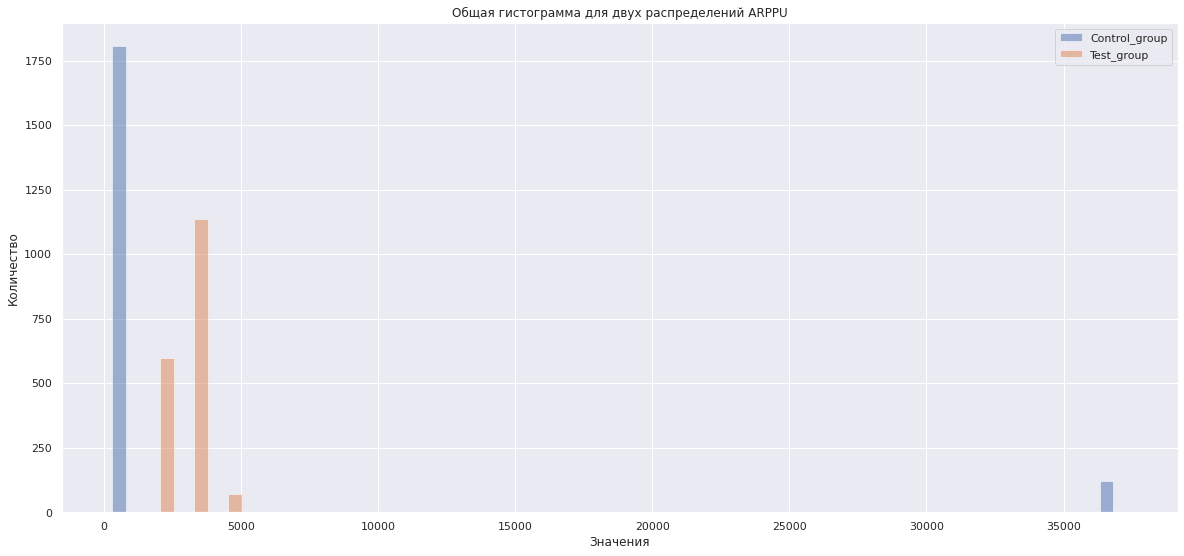

In [29]:
# Посмотрим на соотношение распределений ARPPU в контрольной и тестовой группах. 
plt.hist([control_data_payed.revenue, test_data_payed.revenue], bins=30, alpha=0.5, label=['Control_group', 'Test_group'])
plt.legend(loc='upper right')
plt.title('Общая гистограмма для двух распределений ARPPU')
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.show()

По визуализации видно, что в тестовой группе игроки в общей своей массе платят больше, чем в контрольной. Но в контрольной есть игроки, которые вкладывают денег "ненормально" много.

Попробуем применить t-test. Для этого сформируем гепотезы:
- H0 - статистически значимой разницы между ARPPU контрольной и тестовой группах нет.
- H1 - статистически значимая разница есть
- Пороговое значение p-value < 0.05

In [30]:
# Попробуем применить t-test:
stats.ttest_ind(control_data_payed.revenue, test_data_payed.revenue)

Ttest_indResult(statistic=-1.5917100176862002, pvalue=0.11153459157259504)

p-value > 0.05, значит у нас нет оснований отклонить нулевую гепотезу

t-test не показал стат. значимых различий между ARPPU в контрольной и тестовой группах.

Проверим, есть ли зависимость между группой теста и количеством платящих пользователей в ней, т.е. проверим показатель конверсии в платящего. 

In [31]:
CR_control = control_data.query('revenue > 0')['user_id'].count() / control_data.shape[0]
print(CR_control)

0.009539690157988749


In [32]:
CR_test = test_data.query('revenue > 0')['user_id'].count() / test_data.shape[0]
print(CR_test)

0.008906235351586593


In [33]:
(CR_control - CR_test) /  CR_test * 100

7.112486717401974

Конверсия в покупку в контрольной группе равна 0.0095 или 0.95 %, а конверсия в покупку для тестовой группы равна 0.0089 или 0.89 %. Разница в 7%

Применим критерий XI2, чтобы посмотреть статистически значимы ли эти различия или нет.

In [34]:
# создадим дополнительную колонку в которой если пользователь платил - 1, если не платил - 0
ab_results['payed_user'] = ab_results['revenue'].apply(lambda x: 1 if x > 0 else 0)

In [35]:
ab_results.head(2)

,user_id,revenue,testgroup,payed_user
0,1,0,b,0
1,2,0,a,0


In [36]:
# создаем табличку сопряженности
crosstab = pd.crosstab(ab_results['testgroup'], ab_results['payed_user'])

In [37]:
crosstab

payed_user,0,1
testgroup,,
a,200175,1928
b,200862,1805


Формируем гепотезы:
- H0: нет стат.значимой зависимости между группой а/б теста и количеством платящих пользователей.
- Н1: стат. значимая зависимость есть.

In [42]:
# применяем тест XI2
stat, p, dof, expected = chi2_contingency(crosstab)

print('chi-square stat =', stat)
print('p-value =', p)
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

chi-square stat = 4.374729521260405
p-value = 0.03647561892312613
Отклоняем H0


По всей видимоси статистически значимая разница зависимости между группой теста и количеством платящих пользователей есть. Примем это во внимание.

# Вывод
Сначала сделаем небольшое саммари по нашим гепотезам:
1. ARPU в контрольной группе равен 25.4, а ARPU в тестовой группе равен 25.8. Разница в ARPU 5 %, при этом такая разница не является статистически значимой.
2. ARPPU в контрольной группе равен 2664, а ARPPU в тестовой группе равен 3004. Разница в ARPPU 12.7%, однако такая разница не является статистически значимой.
3. Конверсия в покупку в контрольной группе равна 0.0095 или 0.95 %, а конверсия в покупку для тестовой группы равна 0.0089 или 0.89 %. Разница в 7%. Проверка взаимосвязи количества платящих пользователей от группы теста с помощью XI2 показала статистическую значимость.

Какой основной вывод мы можем сделать исходя из полученных данных?
Основной вывод, который мы можем сделать исходя из полученных данных - нам не удалось доказать, что ARPU и ARPPU в тестовой группе статистически значимо выросли, что говорит нам о том, что новый набор предложений мы не можем считать лучше. А даже наоборот, исходя из показателя конверсии, старый набор предложений пользуется большей популярностью у игроков. Здесь направивается 3 основных вывода:
1. Выборки могут быть не репрезентативные, так-как в тестовой группе у нас нет премиального сегмента. Возможно, проблема сплит-системы. В данном случае есть смысл либо продолжить а/б тест до появления пермиального сегмента в тестовой группе (не всегда возможно, так как период проведения теста ограничен по времени), либо начать тест занаво, предварительно проверив систему a/a тестом.
2. Если мы считаем, что выборки репрезентативны, то наличие премиального сегмента пользователей в контрольной группе идет несомненно в плюс. Обычно такие игроки долго играют в игру и у них большой LTV. Терять таких пользователей мы определенно не можем, поэтому второй набор предложений мы раскатывать не будем.
3. Тест показал, что у нас есть стат. значимая разница в конверсии в платеж, а между ARPU и ARPPU нет. Это может означать, что в динамике первый набор принесет нам больше денег, чем второй. Данный вывод тоже предполагает не раскатывать изменения на всех пользоваталей.

# ЗАДАЧА 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Для оценки результатов последнего прошедшего события можно использовать следующие метрики:

1. Количество игроков, принявших участие в событии - это покажет, насколько популярно событие было у игроков.

2. Количество игроков, которые успешно прошли все уровни события - это даст представление о сложности и интересности события.

3. Среднее время сессии после введения события - это даст нам понимание как событие повлияло на онлайн в игре.

4. DAU, WAU и MAU после введения события (в зависимости от длительности события) - это даст нам понимание, стало ли больше людей играть в нашу игру.

5. Среднее время, затраченное игроками на прохождение всех уровней - это покажет, насколько событие было доступным и увлекательным для игроков.

6. Количество полученных игроками уникальных предметов, бонусов и монет - это даст представление о том, насколько ценными оказались награды события для игроков (чем меньше игроков получили награды, тем она ценнее).

7. Через определенное время по истечении ивента, необходимо опрабить внимание на ARPU и ARPPU - это нам поможет понять, не слишком ли ценные оказались награды и не сломал ли эвент экономику.

Усложняем механику. Теперь при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Предыдущие метрики нас в любом случае интересуют, но добавятся еще некоторые:

8. Количество игроков, которые были отброшены на несколько уровней назад - это покажет, насколько сильно новая механика повлияла на игроков и их способность проходить уровни.

9. Среднее количество попыток, затраченных на прохождение каждого уровня, а также среднее количество уровней, на которое были отброшены игроки - это даст представление о том, насколько сложными оказались уровни с новой механикой для игроков.

10. Количество игроков, которые бросили участие в событии из-за новой механики (churn) - это покажет, насколько она оказалась неудачной и оттолкнула часть игроков.

11. Также целесообразно построить воронку конверсии и посмотреть конкретно из какого уровня в следующий конверсия самая низкая. В идеале это должна быть равномерная воронка конверсии. Если процент конверсии где-то аномально низкий, то такие уровни необходимо перебалансировать.